Note workflow only is for the machine learning, no mapping commands

In [1]:
#basic packages
import os
import pandas as pd
import numpy as np
import warnings
# Plotting
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.gridspec import GridSpec
from scipy import ndimage
#machine learning package
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
#define filepaths
base_dir = os.getcwd()
#well data
file_name_well_data = 'src\df_dataset.csv'
path_dataset = os.path.join(base_dir, file_name_well_data)

#Custom Font
path_robotofont = os.path.join(base_dir, 'RobotoFont')
for font in font_manager.findSystemFonts(path_robotofont):
    font_manager.fontManager.addfont(font)
plt.rcParams['font.family'] = 'Roboto'


In [3]:
def col_filter_keep(df_in, list_keep):
    df_out = df_in.drop(columns=df_in.columns.difference(list_keep))
    return df_out

In [4]:
df_dataset = pd.read_csv(path_dataset)
model_cols_keep = ['Lat_length','Proppant_per_Ft','Fluid_per_Ft','Max_Gas_per_Ft']
df_model = col_filter_keep(df_dataset, model_cols_keep)
df_model.sort_index(axis=1, ascending=True, inplace=True)
df_model.head(3)

,Fluid_per_Ft,Lat_length,Max_Gas_per_Ft,Proppant_per_Ft
0,41.513017,4571,156.941151,1065.880551
1,18.726208,4781,116.352228,817.818239
2,20.250969,4128,157.401163,473.645349


In [5]:
def shuffle_and_split(df_in, shuffle_bool, test_size, y_col):
    if shuffle_bool == True:
        df_shuffled = shuffle(df_in, random_state=13)
    else:
        df_shuffled = df_in
    split_index = int((1-test_size)*len(df_shuffled))
    df_train_set = df_shuffled.iloc[0:split_index,:]
    df_test_set = df_shuffled.iloc[split_index:,:]
    # %train/test split
    X_cols = df_in.columns.difference([y_col]).to_list()
    X_train = df_train_set[X_cols]
    y_train = df_train_set[y_col]
    # test
    X_test = df_test_set[X_cols]
    y_test = df_test_set[y_col]
    return(df_train_set, df_test_set, X_train, y_train, X_test, y_test)

In [6]:
df_train_set, df_test_set, X_train, y_train, X_test, y_test = shuffle_and_split(df_model, False, .05, 'Max_Gas_per_Ft')

In [7]:
X_train.head(3)

,Fluid_per_Ft,Lat_length,Proppant_per_Ft
0,41.513017,4571,1065.880551
1,18.726208,4781,817.818239
2,20.250969,4128,473.645349


In [8]:
#no editable user input here
dict_params = {'n_estimators':25,'max_depth':5,'max_features':3,'min_samples_split':.1}
model_gbm = GradientBoostingRegressor(**dict_params,random_state=0)
#this command trains the model
model_gbm.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=5, max_features=3, min_samples_split=0.1,
                          n_estimators=25, random_state=0)

In [9]:
# Cost Parameters USER INPUT HERE
c_prop = .06 #dollars per pound
c_fluid = 7 #dollars per barrell
c_lat = 200 #dollars per foot
dict_cost_params = {'Fluid_per_bbl':c_fluid, 'Cost_per_lat_ft':c_lat,'Proppant_per_lb':c_prop}

In [10]:
#Helper function for cost model (runs inside "model_mesh" functions)
def cost_model(df_in, y_hat, dict_cost_params):
    df = df_in.copy()
    df['Tot_Fluid']=df['Lat_length']*df['Fluid_per_Ft']
    df['Fluid_Cost']=df['Tot_Fluid']*dict_cost_params['Fluid_per_bbl']
    df['Drilling_Cost']=df['Lat_length']*dict_cost_params['Cost_per_lat_ft']+.5*1000*1000
    df['Tot_Proppant']=df['Lat_length']*df['Proppant_per_Ft']
    df['Proppant_Cost']=df['Tot_Proppant']*dict_cost_params['Proppant_per_lb']
    df['Total_Cost']=df['Fluid_Cost']+df['Drilling_Cost']+df['Proppant_Cost']
    df['Total_Max_Gas']=df['Lat_length']*y_hat
    df['Dollars_per_Max_Gas']=df['Total_Cost']/df['Total_Max_Gas']
    Z = df['Dollars_per_Max_Gas'].values
    return Z

In [11]:
#explanation: designed for a 3 feature model, nsteps is meshgrid dimension
#purpose: finds the "optimum 'X' feature values to maximize y"
#returns a series of the "optimized" engineering or cost features
#bool mode False means engineering parameter optimization bool mode True means cost optimization

def model_3D_meshgrid(trained_model, X, y, feature1, feature2, feature3, nsteps, bool_mode_cost):
    #ranges
    xmin=X_train[feature1].min()
    xmax=X_train[feature1].max()
    ymin=X_train[feature2].min()
    ymax=X_train[feature2].max()
    zmin=X_train[feature3].min()
    zmax=X_train[feature3].max()
    #create meshgrid based on feature ranges
    xx, yy, zz = np.meshgrid(np.linspace(xmin,xmax,nsteps), 
                             np.linspace(ymin, ymax, nsteps), 
                             np.linspace(zmin, zmax, nsteps))
    #pseudo data (meshgrid input to model)
    df_meshgrid = pd.DataFrame({feature1:xx.ravel(),feature2:yy.ravel(),feature3:zz.ravel()})
    
    y_hat = trained_model.predict(df_meshgrid)
    if bool_mode_cost == True:
        Z = cost_model(df_meshgrid, y_hat, dict_cost_params)
        index = np.argmin(Z)
        optimized_val = Z[index]
        optimized_attributes = df_meshgrid.iloc[index,:]
    else:
        index = np.argmax(y_hat)
        optimized_val = y_hat[index]
        optimized_attributes = df_meshgrid.iloc[index,:]
    
    return optimized_attributes, optimized_val


In [12]:
#ensures features are in the same order as the model input (X_train)
dict_features = {key:key_str for key, key_str in zip(
    ['feature1', 'feature2', 'feature3'],X_train.columns)}

In [13]:
dict_args = {'trained_model':model_gbm,'X':X_train,'y':y_train,'nsteps':50,'bool_mode_cost':False}
dict_args.update(dict_features)

optimized_eng_features, optimized_val = [np.round(x,1) for x in model_3D_meshgrid(**dict_args)]
print(optimized_eng_features)
print('Optimized Value {}'.format(optimized_val))

Fluid_per_Ft        35.5
Lat_length         606.0
Proppant_per_Ft    887.4
Name: 1722, dtype: float64
Optimized Value 171.9


In [14]:
# this function calculates the meshgrid of predictions for the heatmap
#inputs are the features to be cross plotted
#output are the xx, yy, Z meshgrid values

def model_2D_meshgrid(trained_model, X, y, str_feature1, str_feature2, str_feature3, ser_vals3, nsteps, bool_mode_cost):
    # feature ranges
    xmin=X_train[str_feature1].min()
    xmax=X_train[str_feature1].max()
    ymin=X_train[str_feature2].min()
    ymax=X_train[str_feature2].max()
    zmin=X_train[str_feature3].min()
    zmax=X_train[str_feature3].max()
    # meshgrid of feature1 and feature2
    xx, yy = np.meshgrid(np.linspace(xmin,xmax,nsteps), np.linspace(ymin, ymax, nsteps))
    #thrid dimension is all constant values
    array_feature3 = np.ones_like(xx.ravel())*ser_vals3[str_feature3]
    dict_arrays = {str_feature1:xx.ravel(),str_feature2:yy.ravel(), str_feature3:array_feature3}
    #order dictionary in same as Xtrain
    dict_meshgrid = {xcol:dict_arrays[xcol] for xcol in X.columns}
    df_meshgrid = pd.DataFrame(dict_meshgrid)
    
    #delta_grid
    grid_d = 3
    grid_x = np.array([grid_d, -grid_d, 0, 0, 0, 0])
    grid_y = np.roll(grid_x, 2)
    grid_z = np.roll(grid_y, 4)
    dx = (xmax-xmin)/(nsteps-1)
    dy = (ymax-ymin)/(nsteps-1)
    dz = (zmax-zmin)/(nsteps-1)
    list_vals=[[ser_vals3[str_feature1], ser_vals3[str_feature2], ser_vals3[str_feature3] ]]
    for x, y, z in zip(grid_x, grid_y, grid_z):
        list_vals.append([dx*x+ser_vals3[str_feature1], dy*y+ser_vals3[str_feature2], dz*z+ser_vals3[str_feature3]])
    
    df_grid = pd.DataFrame(list_vals, columns=[str_feature1, str_feature2, str_feature3])
    df_grid = df_grid[X.columns]
    
    # infer on meshgrid
    y_hat_meshgrid = trained_model.predict(df_meshgrid)
    #infer on stencil around a given point
    y_hat_grid = trained_model.predict(df_grid)
    if bool_mode_cost == True:
        Z = cost_model(df_meshgrid, y_hat_meshgrid, dict_cost_params).reshape(xx.shape)
        y_hat_grid = cost_model(df_grid, y_hat_grid, dict_cost_params)
    else:
        Z = y_hat_meshgrid.reshape(xx.shape)
        y_hat_grid = y_hat_grid
    
    dict_y_hat ={'mean':np.round(np.mean(y_hat_grid),1),'P10':np.round(np.quantile(y_hat_grid,.1),1),
                  'P90':np.round(np.quantile(y_hat_grid,.9),1)}
    
    return xx, yy, Z, dict_y_hat
    

In [15]:
#These dictionaries define the inputs for the "heatmaps"
#heatmap 1
dict_kwargs1 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Proppant_per_Ft','str_feature2':'Fluid_per_Ft','str_feature3':'Lat_length',
               'ser_vals3':optimized_eng_features,'nsteps':50, 'bool_mode_cost':False}
#heatmap 2
dict_kwargs2 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Lat_length','str_feature2':'Fluid_per_Ft','str_feature3':'Proppant_per_Ft',
               'ser_vals3':optimized_eng_features,'nsteps':50, 'bool_mode_cost':False}
#heatmap 3
dict_kwargs3 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Lat_length','str_feature2':'Proppant_per_Ft','str_feature3':'Fluid_per_Ft',
               'ser_vals3':optimized_eng_features,'nsteps':50, 'bool_mode_cost':False}

In [16]:
#demo heatmap format
#xx, yy, Z, dict_y_hat = model_2D_meshgrid(**dict_kwargs1)
#df_out = pd.DataFrame({'xx':xx.ravel(),'yy':yy.ravel(),'Z':Z.ravel()})
#df_out.to_csv('heatplot_data_out.csv')

In [17]:
#plotting helper function: shift text box annotation depending on position within the figure
def annotation_shift(val_x, val_y, x_axis_lims, y_axis_lims):
    xmin=x_axis_lims[0]
    xmax=x_axis_lims[1]
    ymin=y_axis_lims[0]
    ymax=y_axis_lims[1]
    x_range=xmax-xmin
    y_range=ymax-ymin
    marker_x_scaled = (val_x-xmin)/(x_range)
    marker_y_scaled = (val_y-ymin)/(y_range)
    scaled_shift = .05
    #quandrant logic
    if marker_x_scaled < .5 and marker_y_scaled <.5:
        x_shift=scaled_shift*x_range
        y_shift=2*scaled_shift*y_range
    elif marker_x_scaled >=.5 and marker_y_scaled < .5:
        x_shift=-5*scaled_shift*x_range
        y_shift=2*scaled_shift*y_range
    elif marker_x_scaled < .5 and marker_y_scaled >= .5:
        x_shift=scaled_shift*x_range
        y_shift=-2*scaled_shift*y_range
    elif marker_x_scaled >=.5 and marker_y_scaled >= .5:
        x_shift=-5*scaled_shift*x_range
        y_shift=-2*scaled_shift*y_range
    return x_shift, y_shift
    

In [18]:
def plot_meshgrid(meshgrid_args, plotting_args):
    #preliminaries
    #annotation_dictionary to match the user input box
    dict_annotations = {'Proppant_per_Ft':'Proppant (lbs/ft)','Fluid_per_Ft':'Frac Fluid (bbls/ft)',
                        'Lat_length':'Lateral Length (ft)'}
    # plot marker at discreet point (either default optimum value or user input)
    val_x = meshgrid_args['ser_vals3'][meshgrid_args['str_feature1']]
    val_y = meshgrid_args['ser_vals3'][meshgrid_args['str_feature2']]
    val_z = meshgrid_args['ser_vals3'][meshgrid_args['str_feature3']]
    
    #instantiate figure
    fig = plt.figure()
    #creates grid spaces for the subplot figure grid
    gs = GridSpec(4, 4, hspace=0, wspace=0)
    #delcare the axis handles
    ax = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_x = fig.add_subplot(gs[0,0:3])
    ax_hist_y = fig.add_subplot(gs[1:4, 3])
    
    #function to output grid points
    xx, yy, Z, dict_y_hat = model_2D_meshgrid(**meshgrid_args)
    # Apply gaussian filter for to smooth grid prior to contouring (aesthetic tactic)
    Z_filt = ndimage.filters.gaussian_filter(Z, [1,1], mode='reflect')
    
    #calculate "histogram" high/low lines for the range fill plots
    #note: named hist like "histogram" because join plot template has histogram here
    hist_x_max = np.max(Z_filt, axis=0)
    hist_y_max = np.max(Z_filt, axis=1)
    #min-max scale to between 0 and 1
    scaled_x_max = (hist_x_max-np.min(hist_x_max))/(np.max(hist_x_max)-np.min(hist_x_max))
    scaled_y_max = (hist_y_max-np.min(hist_y_max))/(np.max(hist_y_max)-np.min(hist_y_max))
    #FILL BETWEEN PLOTS from -1 to value
    ax_hist_x.fill_between(xx[0,:], scaled_x_max, -1, facecolor='darkgray', alpha=.8, edgecolor='k',linewidth=2)
    ax_hist_y.fill_betweenx(yy[:,0], scaled_y_max, -1, facecolor='darkgray', alpha=.8, edgecolor='k',linewidth=2)
    #FILL BETWEEN PLOT PARAMETERS
    #axis limits
    x_axis_lims = [xx.min(), xx.max()]
    y_axis_lims = [yy.min(), yy.max()]
    ax_hist_x.set_xlim(x_axis_lims)
    ax_hist_x.set_ylim([-1, 2])
    ax_hist_y.set_xlim([-1,2])
    ax_hist_y.set_ylim(y_axis_lims)
    #tick params
    ax_hist_x.set_xticks([])
    ax_hist_x.set_yticks([])
    ax_hist_y.set_xticks([])
    ax_hist_y.set_yticks([])
    
    #HEAT MAP REPLACED WITH CONTOUR PLOT
    cs = ax.contourf(xx, yy, Z_filt, 
                     levels=np.linspace(plotting_args['vmin'],plotting_args['vmax'],plotting_args['cbsteps']),
                     **plotting_args)
    #plot marker
    mrker = ax.plot(val_x, val_y, 'o', markerfacecolor='k', markeredgecolor='k', markeredgewidth=3, ms=8)
    
    #marker annotation positioning logic
    x_shift, y_shift = annotation_shift(val_x, val_y, x_axis_lims, y_axis_lims)
    
    #plot marker annotation
    txt = ax.annotate('    P90 {}\n    Mean {}\n    P10 {}'.format(dict_y_hat['P90'],dict_y_hat['mean'],dict_y_hat['P10']),
                      xy=(val_x, val_y), xycoords='data', xytext=(val_x+x_shift,val_y+y_shift), va='center', weight='heavy', color='k',
                     zorder=5)
    #Colorbar Object  
    bar = fig.colorbar(cs, ax=ax_hist_y)
    
    #Engineering Mode vs. Cost Mode Labels
    if meshgrid_args['bool_mode_cost'] == True:
        str_label_cb = 'Cost of 1st Year Production ($/mcf)'
        str_label_hist = '($/mcf)'
    else:
        str_label_cb = '1st Year Gas Production (mcf/ft)'
        str_label_hist = '(mcf/ft)'
    
    #Axis Labels
    ax_hist_x.set_ylabel(str_label_hist, weight='heavy')
    ax_hist_y.set_xlabel(str_label_hist, weight='heavy')
    
    ax.set_xlabel(dict_annotations[meshgrid_args['str_feature1']],size=12, weight='heavy')
    ax.set_ylabel(dict_annotations[meshgrid_args['str_feature2']],size=12, weight='heavy')
    
    bar.set_label(str_label_cb, size=12) 
    # Chart Title
    #Note Plot Title needs to hover over the "hist_x" axis
    ax_hist_x.set_title('{} = {}'.format(dict_annotations[meshgrid_args['str_feature3']],val_z),
                pad=10, size=14, weight='heavy')
    #write chart out
    plt.savefig(fname='{}_heatmap.png'.format(meshgrid_args['str_feature3']),format='png',dpi=150)

warnings.filterwarnings("ignore")

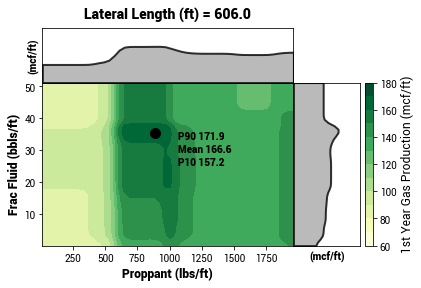

In [19]:
#Heatmap 1 thrid dimension is from optimized features
dict_plotting_args1 = {'vmin':60,'vmax':180,'cbsteps':13, 'cmap':plt.cm.YlGn}

plot_meshgrid(dict_kwargs1, dict_plotting_args1)

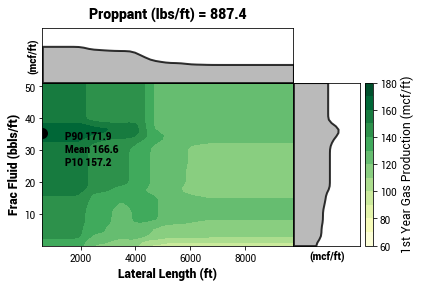

In [20]:
#Heatmap 2
plot_meshgrid(dict_kwargs2, dict_plotting_args1)

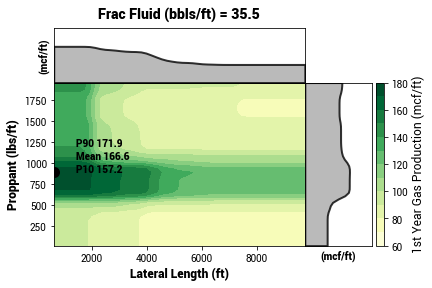

In [21]:
#Heatmap 3
plot_meshgrid(dict_kwargs3, dict_plotting_args1)

In [22]:
#User inputs for third dimension attributes
user_features = optimized_eng_features.copy()
user_features['Fluid_per_Ft'] = 15
user_features['Lat_length']= 4000
user_features['Proppant_per_Ft'] = 1600
user_features

Fluid_per_Ft         15.0
Lat_length         4000.0
Proppant_per_Ft    1600.0
Name: 1722, dtype: float64

In [23]:
#These dictionaries define the inputs for the "heatmaps" with USER INPUT
#heatmap 1 w/User Input
dict_kwargs4 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Proppant_per_Ft','str_feature2':'Fluid_per_Ft','str_feature3':'Lat_length',
               'ser_vals3':user_features,'nsteps':50, 'bool_mode_cost':False}
#heatmap 2 w/User Input
dict_kwargs5 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Lat_length','str_feature2':'Fluid_per_Ft','str_feature3':'Proppant_per_Ft',
               'ser_vals3':user_features,'nsteps':50, 'bool_mode_cost':False}
#heatmap 3 w/User Input
dict_kwargs6 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Lat_length','str_feature2':'Proppant_per_Ft','str_feature3':'Fluid_per_Ft',
               'ser_vals3':user_features,'nsteps':50, 'bool_mode_cost':False}

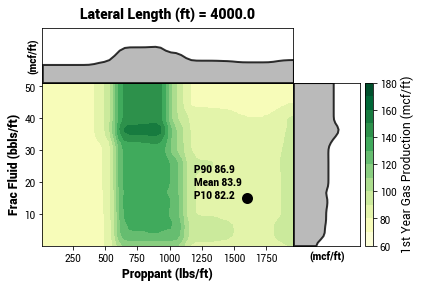

In [24]:
#Heatmap 1 User Input
plot_meshgrid(dict_kwargs4, dict_plotting_args1)

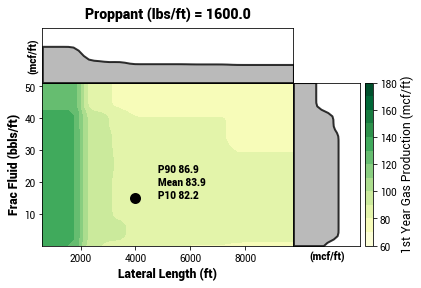

In [25]:
#Heatmap 2 User Input
plot_meshgrid(dict_kwargs5, dict_plotting_args1)

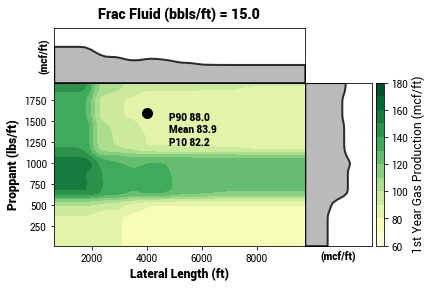

In [26]:
#Heatmap 3 User Input
plot_meshgrid(dict_kwargs6, dict_plotting_args1)

# Cost Optimization Mode 'bool_mode_cost'=True

In [27]:
dict_args = {'trained_model':model_gbm,'X':X_train,'y':y_train,'nsteps':50,'bool_mode_cost':True}
dict_args.update(dict_features)

optimized_cost_features, optimized_val = [np.round(x,1) for x in model_3D_meshgrid(**dict_args)]
print(optimized_cost_features)
print('Optimized Value {}'.format(optimized_val))

Fluid_per_Ft          3.2
Lat_length         9760.0
Proppant_per_Ft    1006.9
Name: 122675, dtype: float64
Optimized Value 2.6


In [28]:
#These dictionaries define the inputs for the "heatmaps"
#heatmap 1
dict_kwargs7 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Proppant_per_Ft','str_feature2':'Fluid_per_Ft','str_feature3':'Lat_length',
               'ser_vals3':optimized_cost_features,'nsteps':50, 'bool_mode_cost':True}
#heatmap 2
dict_kwargs8 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Lat_length','str_feature2':'Fluid_per_Ft','str_feature3':'Proppant_per_Ft',
               'ser_vals3':optimized_cost_features,'nsteps':50, 'bool_mode_cost':True}
#heatmap 3
dict_kwargs9 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Lat_length','str_feature2':'Proppant_per_Ft','str_feature3':'Fluid_per_Ft',
               'ser_vals3':optimized_cost_features,'nsteps':50, 'bool_mode_cost':True}

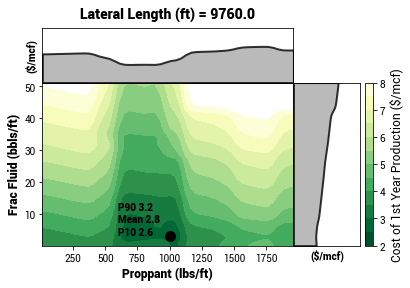

In [29]:
#Heatmap 1 thrid dimension is from optimized features
dict_plotting_args2 = {'vmin':2,'vmax':8,'cbsteps':13, 'cmap':plt.cm.YlGn_r}

plot_meshgrid(dict_kwargs7, dict_plotting_args2)

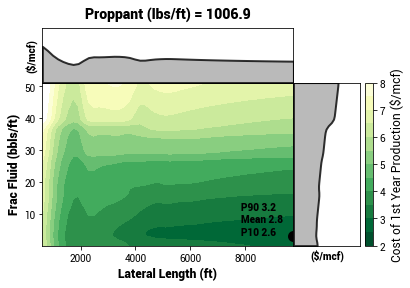

In [30]:
#Heatmap 2 thrid dimension is from optimized features

plot_meshgrid(dict_kwargs8, dict_plotting_args2)

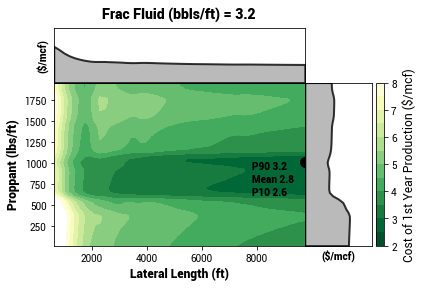

In [31]:
#Heatmap 3 thrid dimension is from optimized features

plot_meshgrid(dict_kwargs9, dict_plotting_args2)

In [32]:
#User inputs for third dimension attributes
user_features = optimized_cost_features.copy()
user_features['Fluid_per_Ft'] = 10
user_features['Lat_length']= 5000
user_features['Proppant_per_Ft'] = 1000
user_features

Fluid_per_Ft         10.0
Lat_length         5000.0
Proppant_per_Ft    1000.0
Name: 122675, dtype: float64

In [33]:
#These dictionaries define the inputs for the "heatmaps" USER INPUTS
#heatmap 1
dict_kwargs10 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Proppant_per_Ft','str_feature2':'Fluid_per_Ft','str_feature3':'Lat_length',
               'ser_vals3':user_features,'nsteps':50, 'bool_mode_cost':True}
#heatmap 2
dict_kwargs11 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Lat_length','str_feature2':'Fluid_per_Ft','str_feature3':'Proppant_per_Ft',
               'ser_vals3':user_features,'nsteps':50, 'bool_mode_cost':True}
#heatmap 3
dict_kwargs12 = {'trained_model':model_gbm,'X':X_train,'y':y_train,
               'str_feature1':'Lat_length','str_feature2':'Proppant_per_Ft','str_feature3':'Fluid_per_Ft',
               'ser_vals3':user_features,'nsteps':50, 'bool_mode_cost':True}

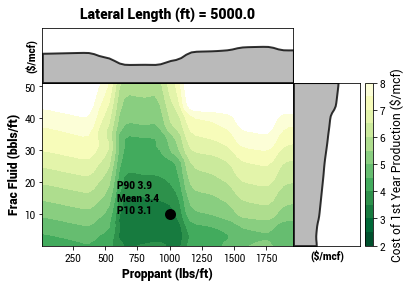

In [34]:
#Heatmap 1 thrid dimension is from USER FEATURES

plot_meshgrid(dict_kwargs10, dict_plotting_args2)

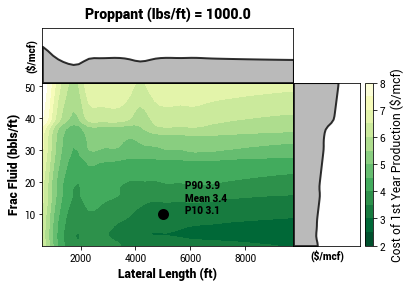

In [35]:
#Heatmap 2 thrid dimension is from User FEatures

plot_meshgrid(dict_kwargs11, dict_plotting_args2)

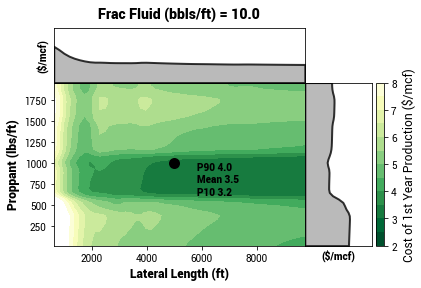

In [36]:
#Heatmap 3 thrid dimension is from User Features

plot_meshgrid(dict_kwargs12, dict_plotting_args2)